In [ ]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from tqdm import tqdm
import pickle
import time 
import talib
import mplfinance as mpf
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

from create_financial_database import get_credentials 
from SQLite_tools import query_stock_data, check_if_close_price_exists
from ticker_loader import load_SPY_components


In [3]:
spy_df = query_stock_data(table="Price_Data", ticker="SPY", start_date="1996-01-01", end_date="2024-07-01")
spy_df["Date"] = pd.to_datetime(spy_df["Date"])
spy_df

,Ticker,Date,Open,High,Low,Close,Adjusted_Close,Adjusted_Scalar,Volume
0,SPY,1996-01-02,37.03641644,37.47930000,36.99872038,37.47930000,37.47930000,0.60313708,310253.71367512
1,SPY,1996-01-03,37.60177815,37.69598796,37.39442006,37.58290000,37.58290000,0.60313581,368093.78326981
2,SPY,1996-01-04,37.63008753,37.77146287,36.92333143,37.22490000,37.22490000,0.60313713,681364.01760890
3,SPY,1996-01-05,36.97983756,37.24371000,36.89503650,37.14950000,37.14950000,0.60313700,182388.63002445
4,SPY,1996-01-08,37.28139107,37.33796529,37.23428609,37.29080000,37.29080000,0.60313676,108504.30338309
...,...,...,...,...,...,...,...,...,...
7167,SPY,2024-06-24,542.66553807,545.27752659,540.96076694,541.08040000,541.08040000,0.99694218,45389481.53347828
7168,SPY,2024-06-25,542.32656858,543.53286860,540.78130822,543.16400000,543.16400000,0.99694217,38156266.58076831
7169,SPY,2024-06-26,542.02746533,544.56966775,541.36948352,543.84190000,543.84190000,0.99694213,38432717.18234313
7170,SPY,2024-06-27,543.70235782,545.28749589,542.94468176,544.69930000,544.69930000,0.99694218,34934349.47187803


In [ ]:
Anualized_Returns = []
years = []
first_open_price = 0
last_close_price = 0
Anualized_Return = 0
currentyear = 0
for idx, row in spy_df.iterrows():
    if currentyear != row["Date"].year:
        if idx > 0:
            last_close_price = row["Close"]
            Anualized_Return = (last_close_price - first_open_price) / first_open_price
            Anualized_Returns.append(Anualized_Return*100)
            years.append(currentyear)
        currentyear = row["Date"].year
        first_open_price = row["Open"]

anualized_returns_df = pd.DataFrame({"Year": years, "Anualized_Return": Anualized_Returns})
print("Mean anlualized return: ", anualized_returns_df["Anualized_Return"].mean())
print("Standard Deviation anlualized return: ", anualized_returns_df["Anualized_Return"].std())
print("Median anlualized return: ", anualized_returns_df["Anualized_Return"].median())
print("Max anlualized return: ", anualized_returns_df["Anualized_Return"].max())
print("Min anlualized return: ", anualized_returns_df["Anualized_Return"].min())
anualized_returns_df["Anualized_Return"].describe()#.to_latex()


Mean anlualized return:  11.047876975957672
Standard Deviation anlualized return:  17.928084130904853
Median anlualized return:  15.148857344482963
Max anlualized return:  34.572317054608625
Min anlualized return:  -35.0317997924537


count    28.00000000
mean     11.04787698
std      17.92808413
min     -35.03179979
25%       1.90410919
50%      15.14885734
75%      25.43354710
max      34.57231705
Name: Anualized_Return, dtype: float64

In [ ]:
monthly_returns = []
dates = []
first_open_price = 0
last_close_price = 0
monthly_return = 0
current_month = 0
for idx, row in spy_df.iterrows():
    if current_month != row["Date"].month:
        if idx > 0:
            last_close_price = row["Close"]
            monthly_return = (last_close_price - first_open_price) / first_open_price
            monthly_returns.append(monthly_return*100)
            dates.append(f"{currentyear} - {current_month}")
        currentyear = row["Date"].year
        current_month = row["Date"].month
        first_open_price = row["Open"]

monthly_returns_df = pd.DataFrame({"Date": dates, "Monthly_Return": monthly_returns})
print("Mean monthly return: ", monthly_returns_df["Monthly_Return"].mean())
print("Standard Deviation monthly return: ", monthly_returns_df["Monthly_Return"].std())
print("Median monthly return: ", monthly_returns_df["Monthly_Return"].median())
print("Max monthly return: ", monthly_returns_df["Monthly_Return"].max())
print("Min anlualized return: ", monthly_returns_df["Monthly_Return"].min())
monthly_returns_df


Mean monthly return:  1.0242350283012487
Standard Deviation monthly return:  4.735733136072428
Median monthly return:  1.6190071692942523
Max monthly return:  14.037427257600237
Min anlualized return:  -16.97227743477384


,Date,Monthly_Return
0,1996 - 1,4.07108382
1,1996 - 2,2.01425395
2,1996 - 3,1.68231005
3,1996 - 4,0.81757401
4,1996 - 5,2.58119826
...,...,...
336,2024 - 1,3.60894756
337,2024 - 2,5.82300589
338,2024 - 3,2.90823347
339,2024 - 4,-4.48237278


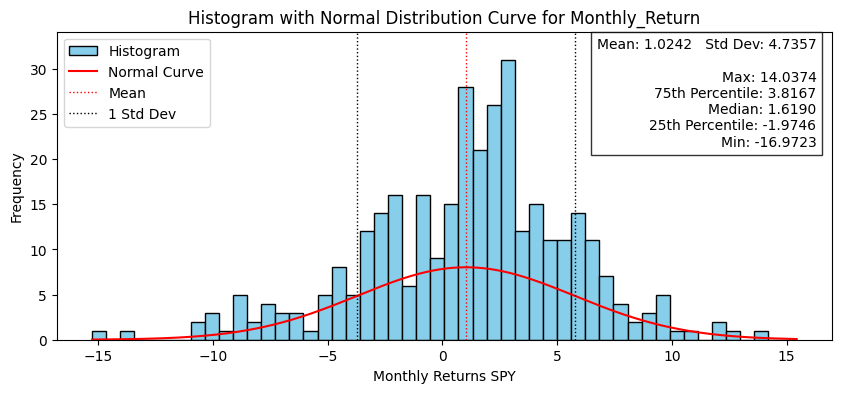

In [ ]:

def plot_histogram_with_statistics(data, column_name, x_axis_label, bins=None, height=4, width=10, y_lim=None, x_range=None, title=None):
    """
    Plots a histogram with detailed statistics and a normal distribution curve.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - column_name: str, name of the column to plot the histogram for.
    - x_axis_label: str, label for the x-axis.
    """
    column_data = data[column_name].dropna()

    mean = column_data.mean()
    std_dev = column_data.std()
    min_val = column_data.min()
    max_val = column_data.max()
    percentile_25 = np.percentile(column_data, 25)
    median = np.median(column_data)
    percentile_75 = np.percentile(column_data, 75)

    plt.figure(figsize=(width, height))

    if x_range != None:
        min_range, max_range = x_range
        
    min_range, max_range = min_val*0.9, max_val*1.1
    if bins == None:
        bins = int((max_range-min_range)*2)
    if bins > 100:
        bins = 100
    elif bins < 10:
        bins = 10

    counts, bin_ranges, patches = plt.hist(column_data, bins=bins, range=(min_range, max_range), color='skyblue', edgecolor='black', label='Histogram')
    plt.ylim(0, max(counts) + max(counts)*0.1)

    y_scale_factor = max(counts)*0.1 * (max_range - min_range)

    x = np.linspace(min_range, max_range, 1000)
    y = norm.pdf(x, mean, std_dev) * y_scale_factor

    plt.plot(x, y, 'r-', label='Normal Curve')

    plt.axvline(mean, color='red', linestyle='dotted', linewidth=1, label='Mean')
    plt.axvline(mean - std_dev, color='black', linestyle='dotted', linewidth=1, label='1 Std Dev')
    plt.axvline(mean + std_dev, color='black', linestyle='dotted', linewidth=1)

    plt.xlabel(x_axis_label)
    plt.ylabel('Frequency')
    if title:
        plt.title(title)
    else:
        plt.title(f'Histogram with Normal Distribution Curve for {column_name}')
    plt.legend(loc='upper left')

    if y_lim:
        plt.ylim(y_lim)
    if x_range:
        plt.xlim(x_range)

    stats_text = (
        f"Mean: {mean:.4f}   Std Dev: {std_dev:.4f}\n \n"
        f"Max: {max_val:.4f}\n"
        f"75th Percentile: {percentile_75:.4f}\n"
        f"Median: {median:.4f}\n"
        f"25th Percentile: {percentile_25:.4f}\n"
        f"Min: {min_val:.4f}"
    )
    plt.text(0.98, 0.98, stats_text, fontsize=10, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

    plt.show()


plot_histogram_with_statistics(monthly_returns_df, "Monthly_Return", "Monthly Returns SPY", bins=50)

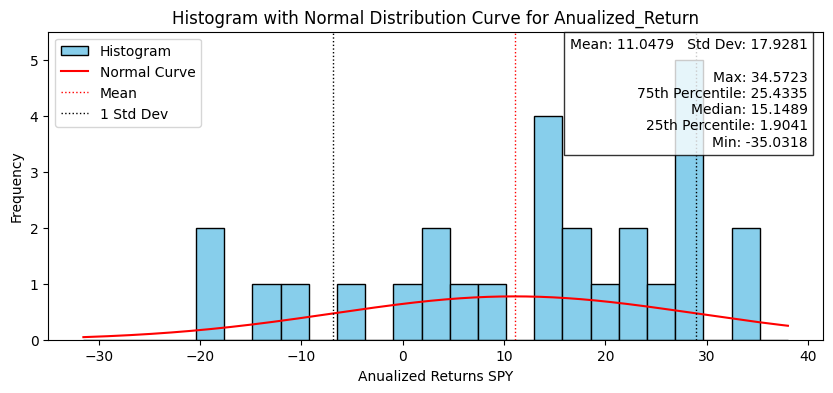

In [6]:
plot_histogram_with_statistics(anualized_returns_df, "Anualized_Return", "Anualized Returns SPY", bins=25)

7171
7171
Mean Daily_Returns:  0.04472602105013001
Standard Deviation Daily_Returns:  1.220224642415602
Median Daily_Returns:  0.06926647512746127
Max Daily_Returns:  14.5196511562069
Min Daily_Returns:  -10.94239397823265


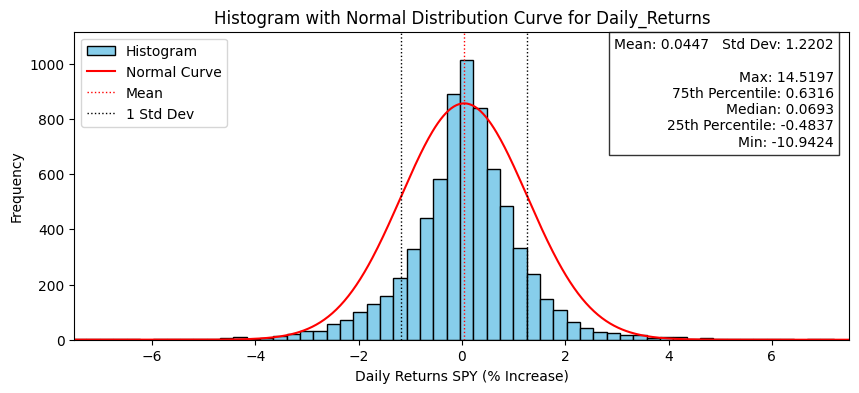

In [ ]:
daily_returns = []
dates = []
first_open_price = 0
last_close_price = 0
monthly_return = 0
current_month = 0
for idx, row in spy_df.iterrows():
    if idx > 0:
        last_close_price = row["Close"]
        daily_return = (last_close_price - first_open_price) / first_open_price
        daily_returns.append(daily_return*100)
        dates.append(row['Date'])
    first_open_price = row["Close"]

print(len(dates))
print(len(daily_returns))

daily_returns_df = pd.DataFrame({"Date": dates, "Daily_Returns": daily_returns})
print("Mean Daily_Returns: ", daily_returns_df["Daily_Returns"].mean())
print("Standard Deviation Daily_Returns: ", daily_returns_df["Daily_Returns"].std())
print("Median Daily_Returns: ", daily_returns_df["Daily_Returns"].median())
print("Max Daily_Returns: ", daily_returns_df["Daily_Returns"].max())
print("Min Daily_Returns: ", daily_returns_df["Daily_Returns"].min())
daily_returns_df

plot_histogram_with_statistics(daily_returns_df, "Daily_Returns", "Daily Returns SPY (% Increase)", bins=100, x_range=(-7.5, 7.5))


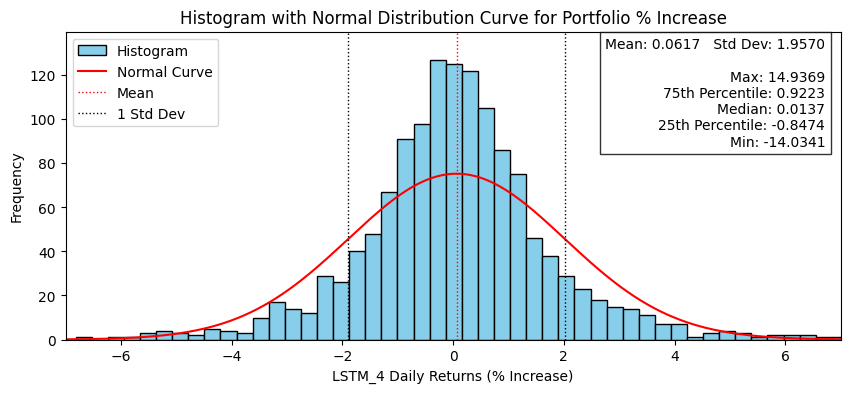

In [ ]:
# model_name = "A3TGCN2_5"
model_name = "LSTM_4"
daily_history  = pd.read_excel(f"../Data/Results/{model_name}_daily_portfolio_history_cost1.xlsx")
local_daily_history = daily_history.copy(deep=True)
local_daily_history = local_daily_history[local_daily_history['Portfolio % Increase'] != 0]

plot_histogram_with_statistics(local_daily_history, "Portfolio % Increase", f"{model_name} Daily Returns (% Increase)", bins=100, x_range=(-7, 7))

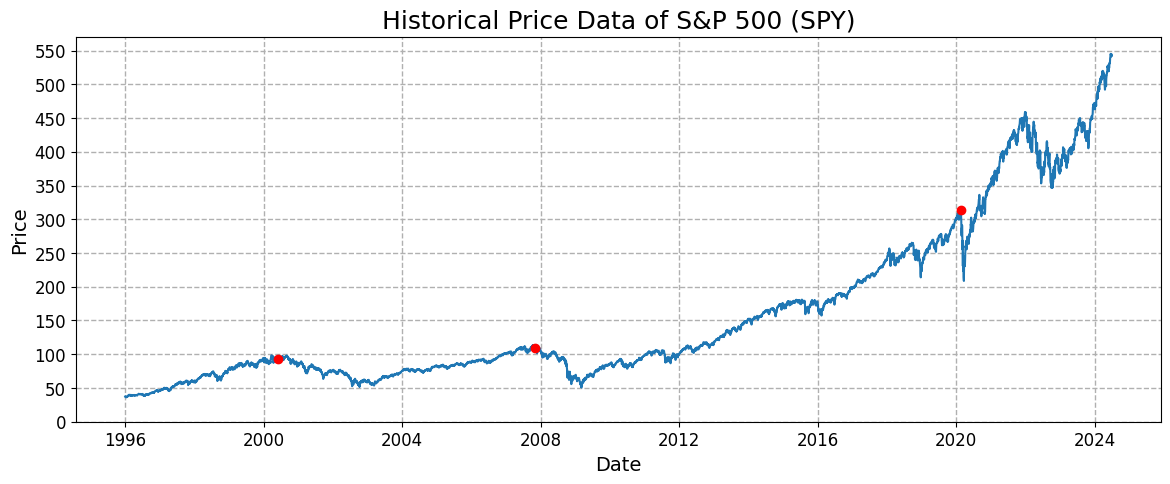

In [ ]:

plt.figure(figsize=(14, 5))
plt.plot(spy_df["Date"], spy_df["Close"], label="Close Price")
plt.title("Historical Price Data of S&P 500 (SPY)", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.plot(datetime(2000, 6, 1), spy_df[spy_df["Date"] == datetime(2000, 6, 1)]["Close"].values[0], 'ro')
plt.plot(datetime(2007, 11, 1), spy_df[spy_df["Date"] == datetime(2007, 11, 1)]["Close"].values[0], 'ro')
plt.plot(datetime(2020, 2, 20), spy_df[spy_df["Date"] == datetime(2020, 2, 20)]["Close"].values[0], 'ro')

plt.yticks(np.arange(0, 600, step=50))

plt.grid(True,  linestyle='--', linewidth=1)

plt.show()


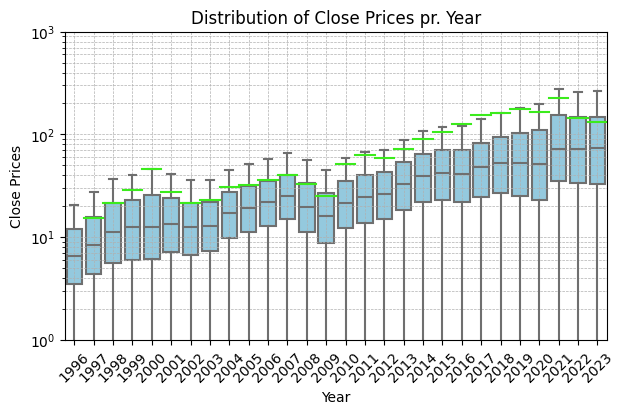

In [ ]:
all_stock_prices = query_stock_data(table="Price_Data", ticker="all_stocks", start_date="1996-01-01", end_date="2024-01-01")

all_stock_prices["Date"] = pd.to_datetime(all_stock_prices["Date"])
all_stock_prices['Year'] = all_stock_prices['Date'].dt.year

plt.figure(figsize=(7, 4))

sns.boxplot(x='Year', y='Close', data=all_stock_prices, color='skyblue', whis=1, showfliers=False)

plt.yscale('log')


plt.title('Distribution of Close Prices pr. Year')
plt.xlabel('Year')
plt.ylabel('Close Prices')
plt.ylim(1, 1000)

plt.xticks(rotation=45)

for i, quarter in enumerate(all_stock_prices['Year'].unique()):
    mean_value = all_stock_prices[all_stock_prices['Year'] == quarter]['Close'].mean()
    if i != 0:
        plt.plot([i - 0.5, i + 0.5], [mean_value, mean_value], color='#3beb1c' if mean_value > 0 else 'red')
    

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

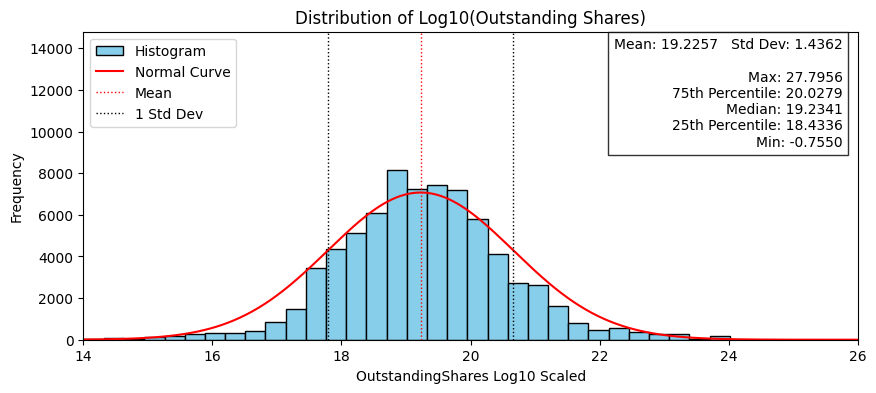

In [ ]:
all_stock_balance_sheets = query_stock_data(table="Balance_Sheets", ticker="all_stocks", start_date="1996-01-01", end_date="2024-01-01")

all_stock_balance_sheets["Date"] = pd.to_datetime(all_stock_balance_sheets["EffectiveDate"])

all_stock_balance_sheets['Year'] = all_stock_balance_sheets['Date'].dt.year

# log transforming the OutstandingShares
all_stock_balance_sheets.drop(all_stock_balance_sheets[all_stock_balance_sheets['OutstandingShares'] <= 0].index, inplace=True)
all_stock_balance_sheets['OutstandingShares'] = np.log(all_stock_balance_sheets['OutstandingShares']) 

plot_histogram_with_statistics(all_stock_balance_sheets, "OutstandingShares", "OutstandingShares Log10 Scaled", bins=500, y_lim=(0, 14800), x_range=(14, 26), title = "Distribution of Log10(Outstanding Shares)")


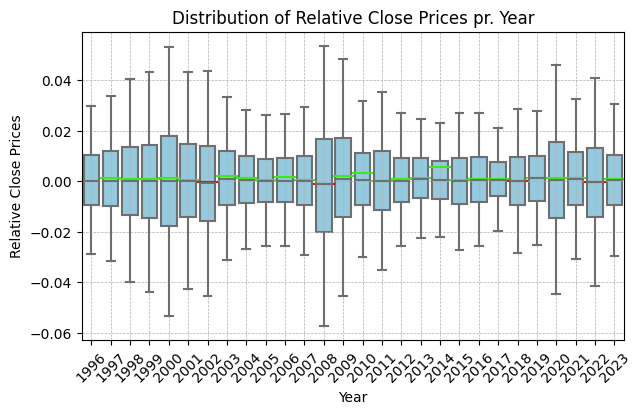

In [ ]:
all_stock_prices = query_stock_data(table="Adjusted_Price_Data", ticker="all_stocks", start_date="1996-01-01", end_date="2024-01-01")

all_stock_prices["Date"] = pd.to_datetime(all_stock_prices["Date"])
all_stock_prices['Year'] = all_stock_prices['Date'].dt.year

plt.figure(figsize=(7, 4))
sns.boxplot(x='Year', y='Close', data=all_stock_prices, color='skyblue', whis=1, showfliers=False)

plt.title('Distribution of Relative Close Prices pr. Year')
plt.xlabel('Year')
plt.ylabel('Relative Close Prices')

plt.xticks(rotation=45)

for i, quarter in enumerate(all_stock_prices['Year'].unique()):
    mean_value = all_stock_prices[all_stock_prices['Year'] == quarter]['Close'].mean()
    if i != 0:
        plt.plot([i - 0.5, i + 0.5], [mean_value, mean_value], color='#3beb1c' if mean_value > 0 else 'red')
    
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [13]:
stock_info = query_stock_data(table="Stocks", ticker="LDG")
stock_info

,Ticker,Name,Currency,Sector,Industry,IPODate,FiscalYearEnd
0,LDG,Longs Drug Stores Corp,USD,Other,Other,None,None


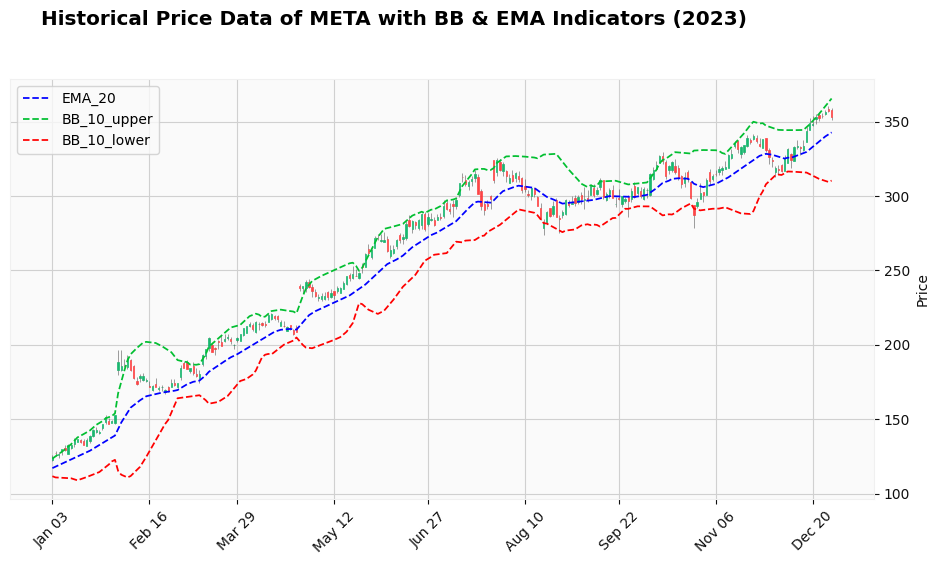

In [ ]:
import talib
import mplfinance as mpf
import matplotlib.dates as mdates

price_df = query_stock_data(table="Price_Data", ticker="META", start_date="2022-11-01", end_date="2024-01-01")
price_df[f'EMA_20'] = talib.EMA(price_df['Close'], timeperiod=20)
price_df[f"BB_20_upper"], price_df[f"BB_20_middle"], price_df[f"BB_20_lower"] = talib.BBANDS(price_df['Close'], timeperiod=20)

price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df = price_df[price_df["Date"] > datetime(2023, 1, 1)]
price_df.set_index('Date', inplace=True)

mpf_data = price_df[['Open', 'High', 'Low', 'Close']]
additional_lines = [
    # mpf.make_addplot(price_df['EMA_10'], color='#03c6fc', linestyle='--', label='EMA_10'),
    mpf.make_addplot(price_df['EMA_20'], color='blue', linestyle='--', label='EMA_20'),
    mpf.make_addplot(price_df['BB_20_upper'], color='#02bf31', linestyle='--', label='BB_10_upper'),
    mpf.make_addplot(price_df['BB_20_lower'], color='red', linestyle='--', label='BB_10_lower'),

]

fig, ax = mpf.plot(
    mpf_data,
    type='candle',
    style='yahoo',
    addplot=additional_lines,
    title="Historical Price Data of META with BB & EMA Indicators (2023)",
    ylabel="Price",
    volume=False,
    figsize=(12, 6),
    returnfig=True
)

ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))



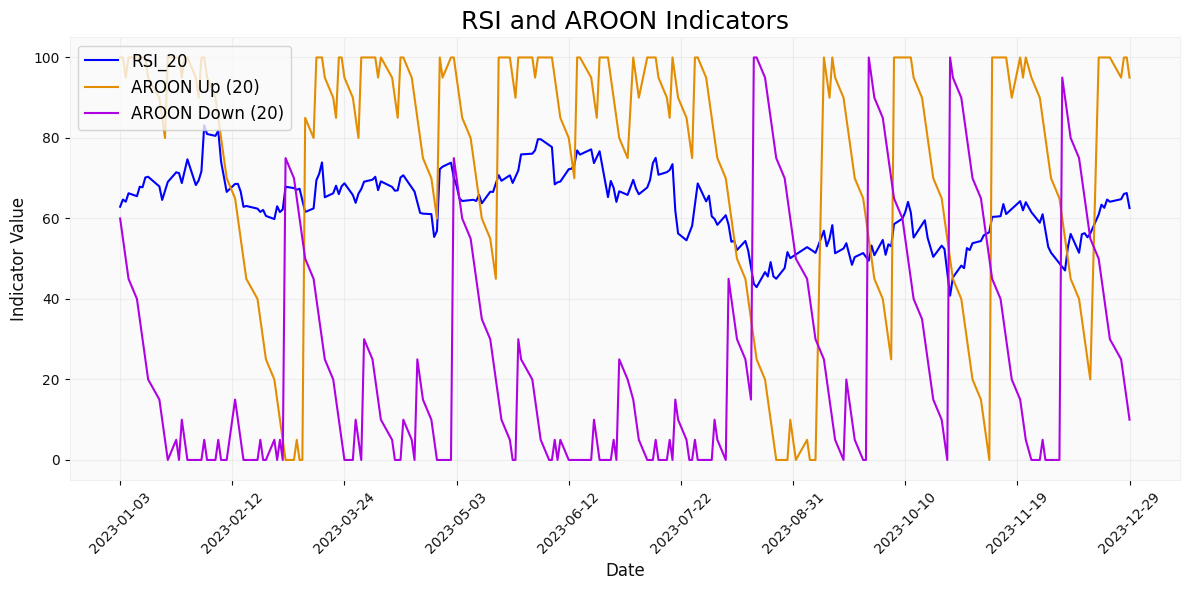

In [ ]:
import talib
import mplfinance as mpf
import matplotlib.dates as mdates

price_df = query_stock_data(table="Price_Data", ticker="META", start_date="2022-11-01", end_date="2024-01-01")
price_df[f'RSI_20'] = talib.RSI(price_df['Close'], timeperiod=20)
price_df[f'AROON_down_20'], price_df[f'AROON_up_20'] = talib.AROON(high = price_df['High'], low = price_df['Low'], timeperiod=20)
price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df = price_df[price_df["Date"] > datetime(2023, 1, 1)]
price_df.set_index('Date', inplace=True)

price_df = price_df[['RSI_20', 'AROON_up_20', 'AROON_down_20']]

plt.figure(figsize=(12, 6))
plt.title('RSI and AROON Indicators', fontsize=18)

plt.plot(price_df.index, price_df['RSI_20'], color='blue', label='RSI_20', linewidth=1.5)
# plt.axhline(70, color='red', linestyle='--', linewidth=1, label='RSI Overbought (70)')
# plt.axhline(30, color='green', linestyle='--', linewidth=1, label='RSI Oversold (30)')

plt.plot(price_df.index, price_df['AROON_up_20'], color='#e38d02', label='AROON Up (20)', linewidth=1.5)
plt.plot(price_df.index, price_df['AROON_down_20'], color='#af02e3', label='AROON Down (20)', linewidth=1.5)

plt.ylim(-5, 105)
plt.ylabel('Indicator Value', fontsize=12)
plt.grid(alpha=0.3)

plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) 

plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


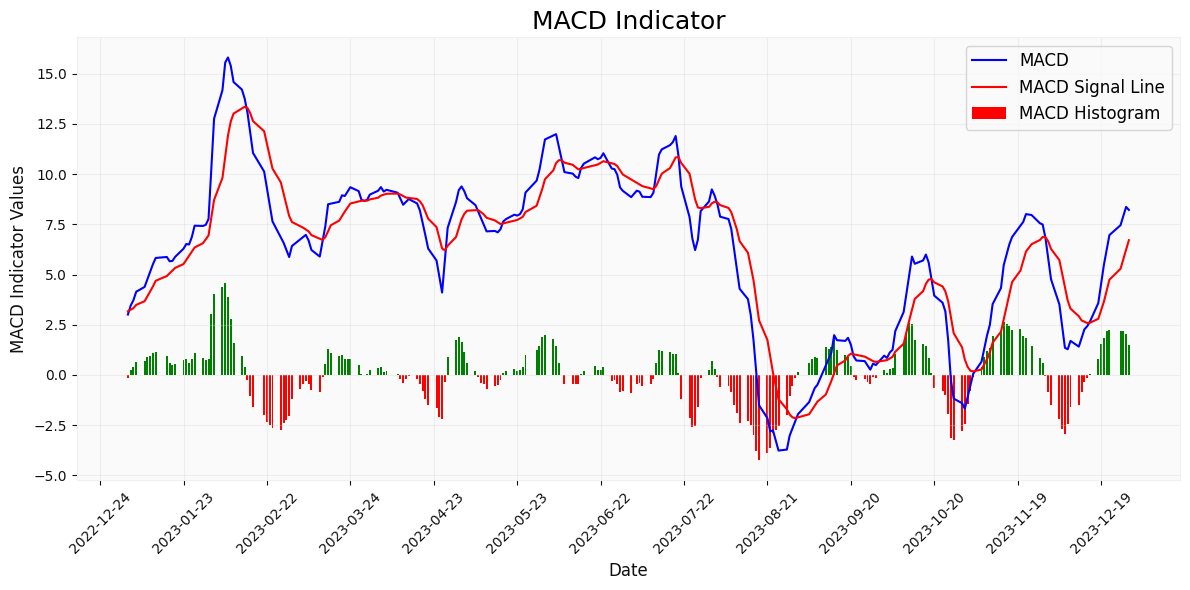

In [ ]:


price_df = query_stock_data(table="Price_Data", ticker="META", start_date="2022-11-01", end_date="2024-01-01")
price_df[f'MACD'], price_df[f'MACD_Signal'], price_df[f'MACD_Hist'] = talib.MACD(price_df['Close'])
price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df = price_df[price_df["Date"] > datetime(2023, 1, 1)]
price_df.set_index('Date', inplace=True)

price_df = price_df[['MACD', 'MACD_Signal', 'MACD_Hist']]

plt.figure(figsize=(12, 6))
plt.title('MACD Indicator', fontsize=18)

plt.plot(price_df.index, price_df['MACD'], color='blue', label='MACD', linewidth=1.5)
plt.plot(price_df.index, price_df['MACD_Signal'], color='red', label='MACD_Signal', linewidth=1.5)
plt.bar(price_df.index, price_df['MACD_Hist'], color=np.where(price_df['MACD_Hist'] > 0, 'green', 'red'), label='MACD_Hist', width=0.7)

plt.ylabel('MACD Indicator Values', fontsize=12)
plt.grid(alpha=0.3)
plt.xlabel('Date', fontsize=12)


plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(14)) 
plt.legend(loc='upper right', fontsize=12, labels=['MACD', 'MACD Signal Line', 'MACD Histogram'])

plt.tight_layout()
plt.show()


In [18]:
ml_feature_table = query_stock_data(table="ML_Feature_Table", ticker="all_stocks", start_date="2024-01-01", end_date="2024-07-01")
ml_feature_table = ml_feature_table.drop(columns=["Date", "Ticker", "Financial_Services", "Healthcare", "Industrials", "Technology", "Consumer_Cyclical", "Healthcare",
                                                     "Industrials", "Technology", "Consumer_Cyclical", "Basic_Materials", "Real_Estate", "Consumer_Defensive", "Utilities", 
                                                     "Communication_Services", "Energy", "Consumer_Discretionary", "Financial", "Financials", "Industrial_Goods",
                                                     "Other", "Services"])
ml_feature_table

,Open,High,Low,Close,EPSActual,EPSDifference,Relative_TotalRevenue,Relative_GrossProfit,Relative_EBIT,Relative_EBITDA,...,ROC_10,ROC_20,BB_upper_10,BB_lower_10,BB_upper_20,BB_lower_20,P_E_Ratio,P_S_Ratio,P_B_Ratio,Active
0,-0.16417831,-0.02135133,-0.32203970,-0.05142017,-0.01396235,-0.01910393,-1.58742552,-2.16911422,-1.12869383,-0.85231698,...,0.54950970,0.47135949,0.38534443,0.33593941,-0.33460163,0.07905100,-0.12814629,-0.05100813,1.65227524,NaN
1,0.05891813,0.27520454,-0.19225317,-0.08062148,0.00119341,-0.11787684,1.88861974,1.21073093,-1.79799767,-1.86443412,...,-0.07963346,-1.34445338,1.96344459,2.27103958,0.42742897,1.63542734,-0.19698478,-0.03727653,2.18655420,NaN
2,0.05813868,0.14839786,-0.01406866,0.06896978,-0.00862582,0.00250265,-0.52761176,-0.12725081,-1.79799767,-1.91318642,...,0.20752086,0.19304865,1.41269215,1.18752911,0.26667701,0.48761383,-0.21441894,-0.51620371,-0.69199850,NaN
3,-0.11588444,0.13002565,-0.57933037,-0.39016877,-0.03808348,-0.01756060,0.03991694,0.08588240,0.34176411,0.30266378,...,0.04568798,-0.26516710,0.88864869,0.82933919,0.36462202,0.44144830,-0.26783651,4.45788457,2.18655420,NaN
4,-0.03799128,0.18474753,-0.19520034,0.08674245,0.24774123,0.52106044,-0.52626192,-0.28164268,-1.34656758,-2.11545506,...,0.75283177,0.90513675,-1.39359593,-1.41405748,-0.31168152,-1.27316739,-0.11184956,0.45197709,0.99298696,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91985,0.07625386,0.12705774,-0.47649241,-0.31798429,-0.02334179,-0.01405970,-0.03665491,1.17227911,0.46008152,0.27366444,...,0.55719095,0.44342017,0.55865789,0.67376041,0.18394443,0.23715068,-0.27342630,-0.45878390,-0.55087213,NaN
91986,-0.13027478,0.42531984,-0.41862135,-0.14785689,-0.04074340,-0.01871493,0.10190062,0.08901920,0.10599695,0.03625239,...,0.43530507,0.30712581,0.52977426,0.20111818,-0.01364610,0.07284659,-0.28271179,-0.70597435,0.70850727,NaN
91987,0.00246234,0.49286123,-0.17155018,0.47704191,-0.02360768,-0.01955218,1.02682639,0.58855039,0.60659726,0.65600050,...,0.45582093,0.68047730,-0.35237486,-0.90550010,-0.03699315,-0.40154730,-0.17494720,4.69803544,-0.04584781,NaN
91988,0.14149504,0.24730866,-0.68059546,-0.63175840,-0.03586246,-0.02181842,0.03996542,0.09664661,-0.15004750,-0.22186860,...,0.73073074,0.55081148,-0.41386543,0.22612363,0.03489763,0.12155192,-0.27294849,-0.46346893,-1.11943254,NaN


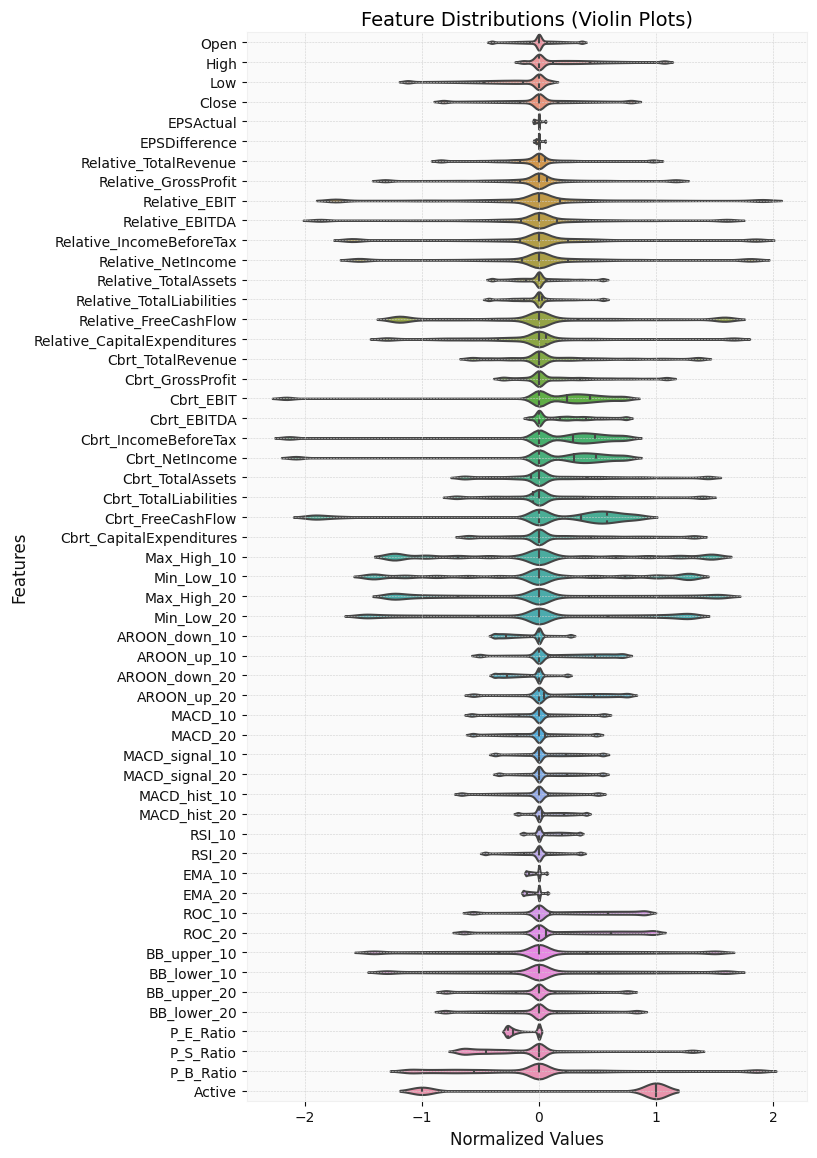

In [ ]:



def remove_percentile_outliers(df, lower_percentile=1, upper_percentile=99):
    """
    Removes the top and bottom outliers based on specified percentiles for each column in the DataFrame.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        lower_percentile (float): The lower percentile threshold (default is 1%).
        upper_percentile (float): The upper percentile threshold (default is 99%).

    Returns:
        pandas.DataFrame: A DataFrame with outliers removed.
    """
    cleaned_df = df.copy()
    for column in cleaned_df.columns:
        lower_bound = np.percentile(cleaned_df[column], lower_percentile)
        upper_bound = np.percentile(cleaned_df[column], upper_percentile)
        cleaned_df[column] = cleaned_df[column].clip(lower=lower_bound, upper=upper_bound)
    return cleaned_df


def create_violin_plots(df, output_file="violin_plots_ml_feature_data.png"):
    """
    Creates a violin plot for each feature in the dataframe, arranged to fit an entire A4 page.

    Parameters:
        df (pandas.DataFrame): The input dataframe with features as columns.
        output_file (str): The file path where the violin plots image will be saved.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(8.27, 11.69)) 
    melted_df = df.melt(var_name="Feature", value_name="Value")
    
    sns.violinplot(
        data=melted_df,
        y="Feature",
        x="Value",
        scale="width",
        inner="quartile",
        ax=ax
    )

    ax.set_title("Feature Distributions (Violin Plots)", fontsize=14)
    ax.set_xlabel("Normalized Values", fontsize=12)
    ax.set_ylabel("Features", fontsize=12)

    plt.grid(True, which='major', linestyle='--', linewidth=0.4)

    plt.tight_layout()
    plt.savefig("../Docs/ScreenShots/"+output_file)
    plt.show()

new_ml_feature_table = remove_percentile_outliers(ml_feature_table, lower_percentile=5, upper_percentile=95)
create_violin_plots(new_ml_feature_table)


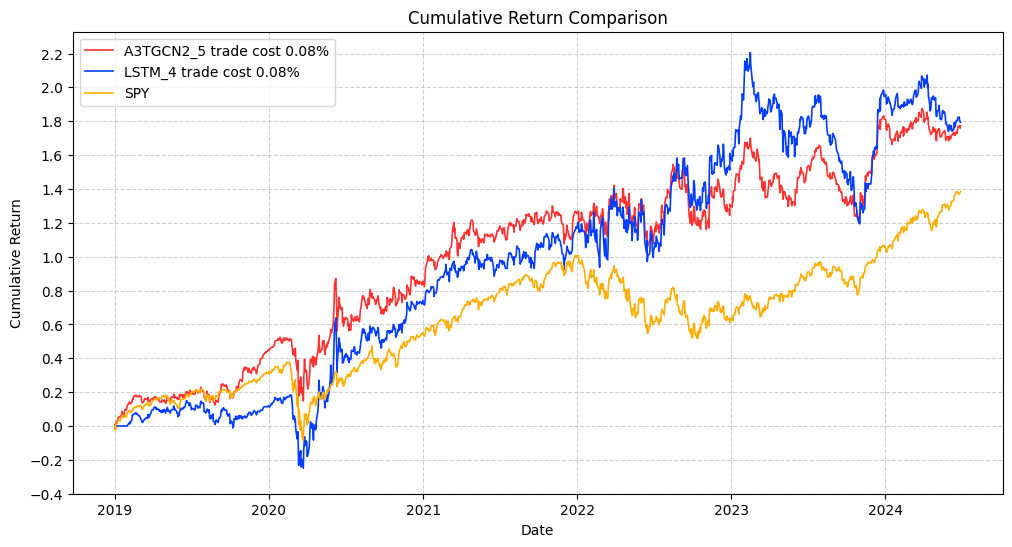

,Metric,A3TGCN2_5 cost 0%,A3TGCN2_5 cost 0.08%,LSTM_4 cost 0%,LSTM_4 cost 0.08%,SPY
0,Cumulative Return %,190.28100000,177.24400000,190.62300000,179.41500000,138.48300000
1,Annualized Return %,21.46600000,20.45100000,21.49200000,20.62300000,17.18600000
2,Annualized Std %,23.93100000,23.93300000,30.60000000,30.60900000,20.28400000
3,Max Drawdown %,-24.56600000,-24.65200000,-36.59500000,-36.59500000,-33.71700000
4,Sharpe Ratio,0.77200000,0.72900000,0.60400000,0.57600000,0.69900000


In [ ]:

def financial_metrics(daily_returns, risk_free_rate=0.02, trading_days=252):
    """
    Calculate financial metrics from daily returns.

    Parameters:
    - daily_returns: List or numpy array of daily returns.
    - risk_free_rate: Annual risk-free rate, default is 2% (0.02).
    - trading_days: Number of trading days in a year, default is 252.

    Returns:
    - A dictionary containing annualized returns, standard deviation of annualized returns,
      maximum drawdown, and Sharpe ratio.
    """

    daily_returns = np.array(daily_returns)

    cumulative_return = np.prod(1 + daily_returns) - 1
    cumulative_return_list = np.cumprod(1 + daily_returns) - 1

    annualized_return = (1 + cumulative_return) ** (trading_days / len(daily_returns)) - 1

    daily_std = np.std(daily_returns, ddof=1)
    annualized_std = daily_std * np.sqrt(trading_days)

    cumulative_returns = np.cumprod(1 + daily_returns)
    drawdowns = cumulative_returns / np.maximum.accumulate(cumulative_returns) - 1
    max_drawdown = drawdowns.min()

    excess_return = annualized_return - risk_free_rate

    sharpe_ratio = excess_return / annualized_std if annualized_std != 0 else np.nan

    return {
        "Cumulative Return": cumulative_return_list,
        "Annualized Return": annualized_return,
        "Annualized Std": annualized_std,
        "Maximum Drawdown": max_drawdown,
        "Sharpe Ratio": sharpe_ratio
    }



def calculate_financial_ratios_and_compare(start_date, end_date, trading_days = 252, risk_free_rate = 0.03):
    """
    Calculate financial ratios and compare the performance of SPY with the GNN model (AT-GCN).

    Parameters:
    - daily_history: DataFrame containing "Date", "Returns (%)", "Previous Portfolio Value (USD)",
                        "Portfolio Value (USD)", "Portfolio Composition".

    Returns:
    - A dictionary containing financial ratios and performance comparison.
    """
    model_name_1 = "A3TGCN2_5"
    model_name_2 = "LSTM_4"

    daily_history_df0  = pd.read_excel(f"../Data/Results/{model_name_1}_daily_portfolio_history_cost0.xlsx")
    daily_history_df0 = daily_history_df0[(daily_history_df0['Date'] >= start_date) & (daily_history_df0['Date'] <= end_date)]

    daily_history_df1  = pd.read_excel(f"../Data/Results/{model_name_1}_daily_portfolio_history_cost8.xlsx")
    daily_history_df1 = daily_history_df1[(daily_history_df1['Date'] >= start_date) & (daily_history_df1['Date'] <= end_date)]

    daily_history_df2  = pd.read_excel(f"../Data/Results/{model_name_2}_daily_portfolio_history_cost0.xlsx")
    daily_history_df2 = daily_history_df2[(daily_history_df2['Date'] >= start_date) & (daily_history_df2['Date'] <= end_date)]

    daily_history_df3  = pd.read_excel(f"../Data/Results/{model_name_2}_daily_portfolio_history_cost8.xlsx")
    daily_history_df3 = daily_history_df3[(daily_history_df3['Date'] >= start_date) & (daily_history_df3['Date'] <= end_date)]

    spy_df = query_stock_data(table="Price_Data", ticker="SPY", start_date=daily_history_df0['Date'].min(), end_date=daily_history_df0['Date'].max())

    daily_history_df0['Date'] = pd.to_datetime(daily_history_df0['Date'])
    daily_history_df1['Date'] = pd.to_datetime(daily_history_df1['Date'])
    daily_history_df2['Date'] = pd.to_datetime(daily_history_df2['Date'])
    daily_history_df3['Date'] = pd.to_datetime(daily_history_df3['Date'])

    daily_history_df0 = daily_history_df0[['Date', 'Returns (%)']]
    daily_history_df1 = daily_history_df1[['Date', 'Returns (%)']]
    daily_history_df2 = daily_history_df2[['Date', 'Returns (%)']]
    daily_history_df3 = daily_history_df3[['Date', 'Returns (%)']]
    
    daily_history_df0 = daily_history_df0.rename(columns={'Returns (%)': f'{model_name_1} Returns (%) cost 0%'})   
    daily_history_df1 = daily_history_df1.rename(columns={'Returns (%)': f'{model_name_1} Returns (%) cost 0.08%'})
    daily_history_df2 = daily_history_df2.rename(columns={'Returns (%)': f'{model_name_2} Returns (%) cost 0%'})
    daily_history_df3 = daily_history_df3.rename(columns={'Returns (%)': f'{model_name_2} Returns (%) cost 0.08%'})

    spy_df['Date'] = pd.to_datetime(spy_df['Date'])
    spy_df = spy_df.rename(columns={'Close': 'SPY Close'})

    merged_df = pd.merge(daily_history_df0, spy_df, on='Date', how='inner')
    merged_df = pd.merge(daily_history_df1, merged_df, on='Date', how='inner')
    merged_df = pd.merge(daily_history_df2, merged_df, on='Date', how='inner')
    merged_df = pd.merge(daily_history_df3, merged_df, on='Date', how='inner')

    merged_df['SPY Returns (%)'] = merged_df['SPY Close'].pct_change()
    merged_df.loc[0,'SPY Returns (%)'] = 0
    
    model_financial_metrics0 = financial_metrics(merged_df[f'{model_name_1} Returns (%) cost 0%'], risk_free_rate=risk_free_rate, trading_days=trading_days)
    model_financial_metrics1 = financial_metrics(merged_df[f'{model_name_1} Returns (%) cost 0.08%'], risk_free_rate=risk_free_rate, trading_days=trading_days)
    model_financial_metrics2 = financial_metrics(merged_df[f'{model_name_2} Returns (%) cost 0%'], risk_free_rate=risk_free_rate, trading_days=trading_days)
    model_financial_metrics3 = financial_metrics(merged_df[f'{model_name_2} Returns (%) cost 0.08%'], risk_free_rate=risk_free_rate, trading_days=trading_days)
    spy_financial_metrics    = financial_metrics(merged_df['SPY Returns (%)'], risk_free_rate=risk_free_rate, trading_days=trading_days)

    merged_df[f'{model_name_1} Cumulative Return cost 0%'] =  model_financial_metrics0['Cumulative Return']
    merged_df[f'{model_name_1} Cumulative Return cost 0.08%'] =  model_financial_metrics1['Cumulative Return']
    merged_df[f'{model_name_2} Cumulative Return cost 0%'] =  model_financial_metrics2['Cumulative Return']
    merged_df[f'{model_name_2} Cumulative Return cost 0.08%'] =  model_financial_metrics3['Cumulative Return']
    merged_df['SPY Cumulative Return']    =  spy_financial_metrics['Cumulative Return']

    

    performance_comparison = pd.DataFrame({
        'Metric': ['Cumulative Return %','Annualized Return %', "Annualized Std %", 'Max Drawdown %','Sharpe Ratio'],
        f'{model_name_1} cost 0%': [model_financial_metrics0["Cumulative Return"][-1]*100,model_financial_metrics0["Annualized Return"]*100, 
                    model_financial_metrics0["Annualized Std"]*100, 
                    model_financial_metrics0["Maximum Drawdown"]*100, model_financial_metrics0["Sharpe Ratio"]],
        f'{model_name_1} cost 0.08%': [model_financial_metrics1["Cumulative Return"][-1]*100,model_financial_metrics1["Annualized Return"]*100, 
                    model_financial_metrics1["Annualized Std"]*100, 
                    model_financial_metrics1["Maximum Drawdown"]*100, model_financial_metrics1["Sharpe Ratio"]],
        f'{model_name_2} cost 0%': [model_financial_metrics2["Cumulative Return"][-1]*100,model_financial_metrics2["Annualized Return"]*100,
                    model_financial_metrics2["Annualized Std"]*100,
                    model_financial_metrics2["Maximum Drawdown"]*100, model_financial_metrics2["Sharpe Ratio"]],
        f'{model_name_2} cost 0.08%': [model_financial_metrics3["Cumulative Return"][-1]*100,model_financial_metrics3["Annualized Return"]*100,
                    model_financial_metrics3["Annualized Std"]*100, 
                    model_financial_metrics3["Maximum Drawdown"]*100, model_financial_metrics3["Sharpe Ratio"]],      
        'SPY': [spy_financial_metrics["Cumulative Return"][-1]*100, spy_financial_metrics["Annualized Return"]*100, 
                spy_financial_metrics["Annualized Std"]*100,
                spy_financial_metrics["Maximum Drawdown"]*100, spy_financial_metrics["Sharpe Ratio"]]
    })
    
    performance_comparison = performance_comparison.round(3)

    plt.figure(figsize=(12, 6))
    # plt.plot(merged_df['Date'], merged_df[f'{model_name_1} Cumulative Return cost 0%'], label=f'{model_name_1} ', color=  "#ff3232", linestyle='-', linewidth=0.5)
    plt.plot(merged_df['Date'], merged_df[f'{model_name_1} Cumulative Return cost 0.08%'], label=f'{model_name_1} trade cost 0.08%', color=  "#ff3232", linestyle='-' , linewidth=1.2)
    # plt.plot(merged_df['Date'], merged_df[f'{model_name_2} Cumulative Return cost 0%'], label=f'{model_name_2} ', color=  "#1bc0cc", linestyle='-', linewidth=0.5)
    plt.plot(merged_df['Date'], merged_df[f'{model_name_2} Cumulative Return cost 0.08%'], label=f'{model_name_2} trade cost 0.08%', color = "#033dff", linestyle='-' , linewidth=1.2)
    plt.plot(merged_df['Date'], merged_df['SPY Cumulative Return'], label='SPY', color = "#ffaf03", linewidth=1.2)
    plt.title('Cumulative Return Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.yticks(np.arange(-0.4, 2.21, 0.2))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

    return performance_comparison


start_date = "2018-11-05"
end_date = "2024-06-29"

performance_table = calculate_financial_ratios_and_compare(start_date, end_date)
performance_table

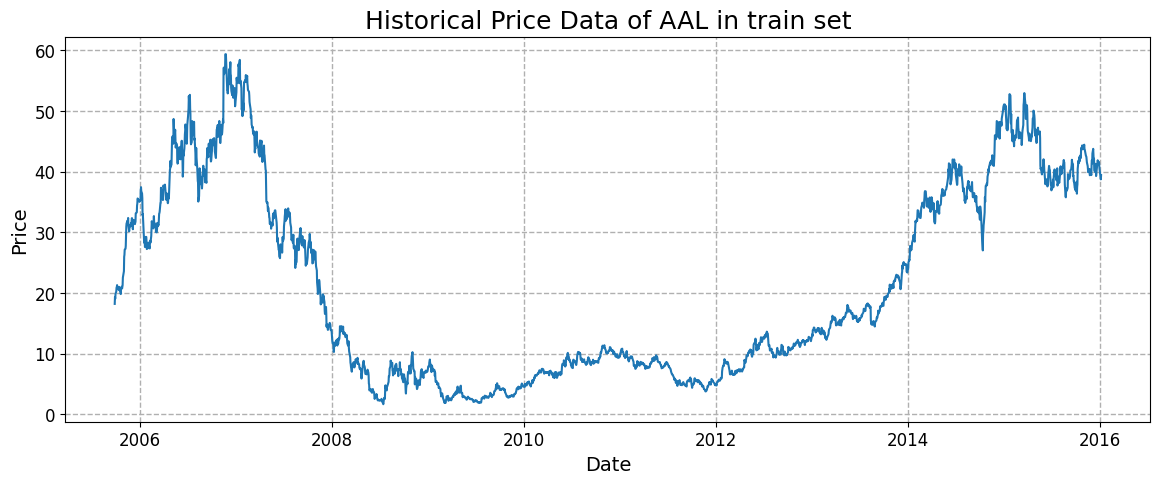

In [ ]:
aal_df = query_stock_data(table="Price_Data", ticker="AAL", start_date="1996-01-01", end_date="2016-01-07")

aal_df["Date"] = pd.to_datetime(aal_df["Date"])

plt.figure(figsize=(14, 5))
plt.plot(aal_df["Date"], aal_df["Close"], label="Close Price")
plt.title("Historical Price Data of AAL in train set", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.grid(True,  linestyle='--', linewidth=1)
plt.show()


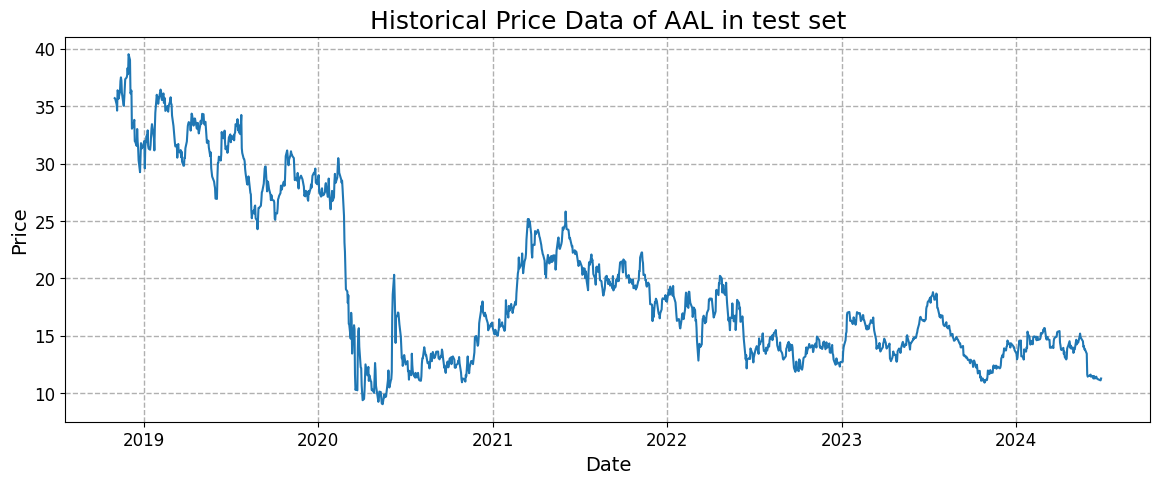

In [ ]:
aal_df = query_stock_data(table="Price_Data", ticker="AAL", start_date="2018-11-01", end_date="2024-06-28")

aal_df["Date"] = pd.to_datetime(aal_df["Date"])

plt.figure(figsize=(14, 5))
plt.plot(aal_df["Date"], aal_df["Close"], label="Close Price")
plt.title("Historical Price Data of AAL in test set", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.grid(True,  linestyle='--', linewidth=1)
plt.show()
